# CYPLAN255
### Urban Informatics and Visualization

HIT RECORD and TRANSCRIBE

# Lecture 18 -- Making maps
******
March 28, 2022

<img src="https://pbs.twimg.com/media/EWZOf79X0AYkKwh?format=jpg&name=large" width=500 align='right' title='1928 The house band for the Michelin Radio hour. c. 1928'>

# Agenda
1. Announcements
2. Static maps
3. Project breakout groups
4. For next time
5. Questions


# 1. Announcements

- Submit your final project groups by Sunday!
- I will be randomly assigning presentation days accordingly.

# 2. Static Maps

Imports

In [1]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as cx

In [2]:
import geoplot

ModuleNotFoundError: No module named 'geoplot'

Let's grab some data we've already worked with

In [4]:
storefronts = gpd.read_file('https://github.com/dillonma/storefrontindex/raw/master/all56_nACSxMSA__41860.0.geojson')
tracts = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_06_tract10.zip")
tracts = tracts[tracts['COUNTYFP10'].isin(['001', '013', '041', '075', '081'])]

## 2.1. GeoPandas

This section should mostly be review. If you're feeling lost, refer back to the lecture 13 and 14 notebooks.

### 2.1.1. Point Plot

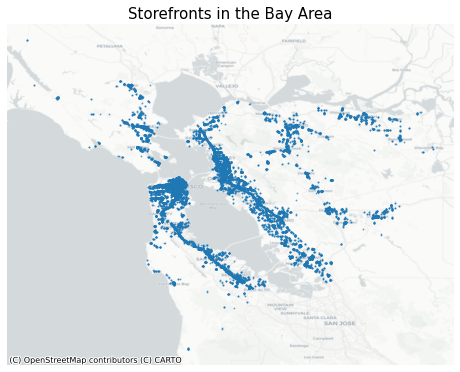

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
storefronts.plot(markersize=1, ax=ax, alpha=0.5)
ax.axis('off')
ax.set_title("Storefronts in the Bay Area", fontsize=15)
cx.add_basemap(
    ax,
    crs=storefronts.crs.to_string(),
    source=cx.providers.CartoDB.Positron)
plt.show()

### 2.1.2. Adding Data Layers

The biggest single improvement we can make is probably to add in the coastline, which will give people familiar with the Bay Area a clearer sense of what they're looking at.

Remember, when dealing with multiple layers of geospatial data, you'll need to make sure that the CRS's match!

**Useful sources for background data**

When you start visualizing geosptial data, all of a sudden you have to find appropriate *background* datasets to include in your maps: country borders, states, counties, etc. 

[Natural Earth](https://www.naturalearthdata.com), mentioned above, is a nice resource for this. So is the U.S. Census [TIGER](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) data. That stands for Topologically Integrated Geographic Encoding and Referencing, obviously.

Generally, you want to look for what's called "cartographic" shapefiles for this: not the administrative boundaries, which might extend out into the ocean, but the common-sense boundaries that people are most familiar with.

In [6]:
outlines = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_500k.zip')
outlines = outlines[outlines['GEOID'] == '06']  # just CA
outlines

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
4,06,01779778,0400000US06,06,CA,California,00,403501101370,20466718403,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."


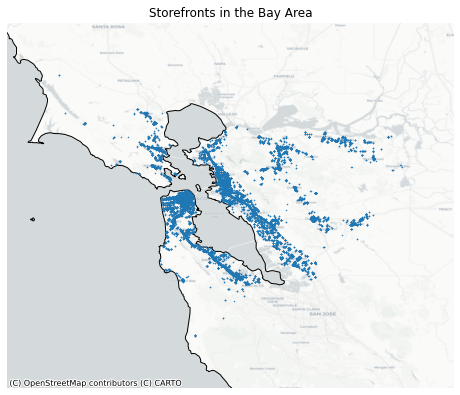

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
outlines.plot(ax=ax, facecolor='none')
storefronts.to_crs(outlines.crs).plot(markersize=1, ax=ax, marker='.')
ax.set_title("Storefronts in the Bay Area")

buff = .2
ax.set_xlim(storefronts['geometry'].x.min() - buff, storefronts['geometry'].x.max() + buff)
ax.set_ylim(storefronts['geometry'].y.min() - buff, storefronts['geometry'].y.max() + buff)
ax.axis('off')
cx.add_basemap(
    ax,
    crs=storefronts.crs.to_string(),
    source=cx.providers.CartoDB.Positron)
plt.show()

### 2.1.3. Basic Choropleth

In [8]:
storefronts.index.name = 'storefront_id'
storefronts.reset_index(inplace=True)

In [9]:
tracts_w_stores = gpd.sjoin(storefronts, tracts.to_crs(storefronts.crs), how='inner', predicate='within')
tract_counts = tracts_w_stores.groupby('GEOID10')['storefront_id'].count().reset_index()
tracts = pd.merge(tracts, tract_counts, on='GEOID10', how='left')
tracts['store_count'] = tracts['storefront_id'].fillna(0)
tracts = tracts.clip(outlines.to_crs(tracts.crs))  # clip tract geoms to coastline

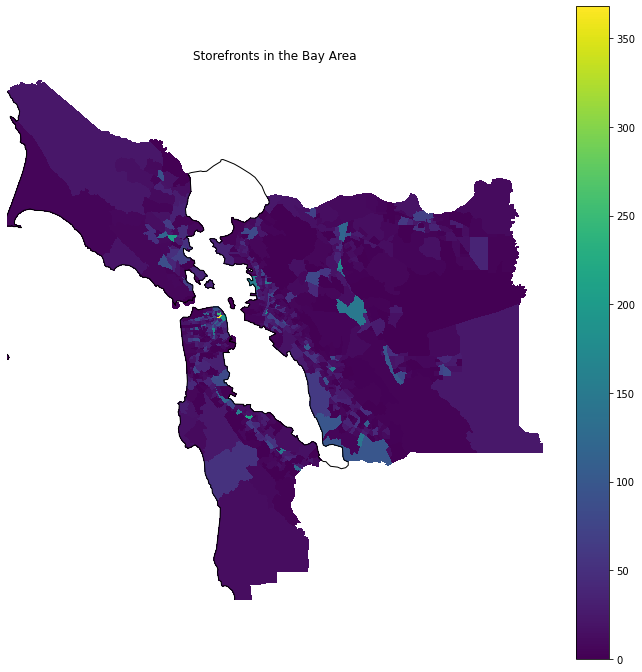

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))

tracts.plot(
    column='store_count',
    ax=ax,
    legend=True,
    antialiased=False
    
)
outlines.plot(ax=ax, facecolor='none')
ax.set_title("Storefronts in the Bay Area")

buff = .1
ax.set_xlim(storefronts['geometry'].x.min() - buff, storefronts['geometry'].x.max() + buff)
ax.set_ylim(storefronts['geometry'].y.min() - buff, storefronts['geometry'].y.max() + buff)
ax.axis('off')
plt.show()

### 2.1.3. Normalize by Unit Area

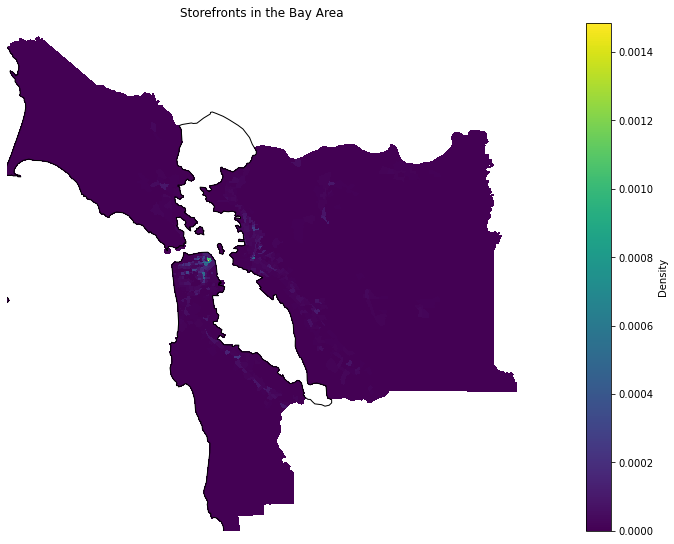

In [11]:
fig, ax = plt.subplots(figsize=(12, 12))

tracts['store_density'] = tracts['store_count'] / tracts['ALAND10']

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)

tracts.plot(
    column='store_density',
    edgecolor='none',
    ax=ax,
    cax=cax, 
    legend=True,
    legend_kwds={'label': 'Density'},
    antialiased=False
)
outlines.plot(ax=ax, facecolor='none', )
ax.set_title("Storefronts in the Bay Area")

buff = .1
ax.set_xlim(storefronts['geometry'].x.min() - buff, storefronts['geometry'].x.max() + buff)
ax.set_ylim(storefronts['geometry'].y.min() - buff, storefronts['geometry'].y.max() + buff)

ax.axis('off')

plt.show()

### 2.1.4. Alternative Classification Schemes

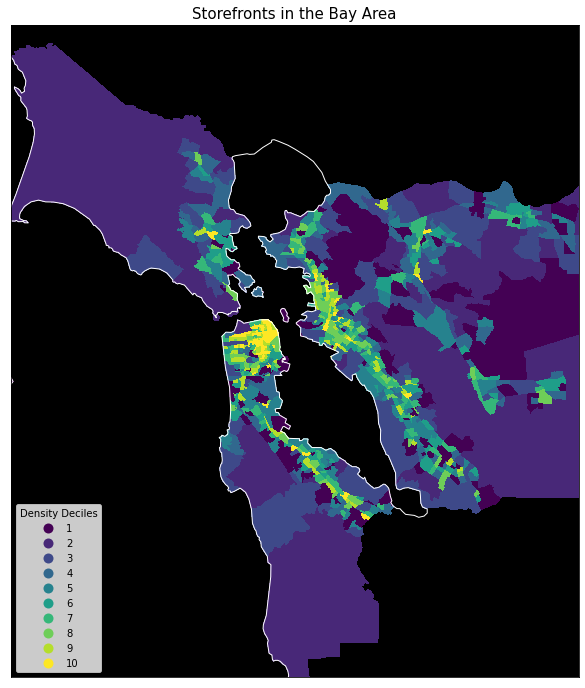

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))

tracts.plot(
    column='store_density',
    edgecolor='none',
    lw=.01,
    ax=ax,
    k=10,  # number of bins
    scheme='quantiles',  # choropleth classification scheme
    legend=True,
    legend_kwds={
        'title': 'Density Deciles',
        'loc':'lower left',
        'labels': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    },
    antialiased=False  # turn off 

)
outlines.plot(ax=ax, facecolor='none', edgecolor='white')
ax.set_title("Storefronts in the Bay Area", fontsize=15)

buff = .1
ax.set_xlim(storefronts['geometry'].x.min() - buff, storefronts['geometry'].x.max() - buff)
ax.set_ylim(storefronts['geometry'].y.min() - buff, storefronts['geometry'].y.max() + buff)
ax.set_facecolor('k')
ax.set_xticks([])
ax.set_yticks([])

plt.show()

### Exercises
Geopandas uses a library called `mapclassify` to implement the choropleth classification schemes. Check out the documentation here for all of the available options: https://pysal.org/mapclassify/api.html
1. Try implementing two different classifaction schemes. 
2. Try using quantiles to visualize the original storefront counts (not densities). How does it compare to the density quantiles?

## 2.2. Map tiles

You are probably a lot more familiar with **map tiles** than you think. If you have ever used Google Maps, Apple Maps, Bing Maps, OpenStreetMap, you have used map tiles. Broadly speaking, map tiles are how interactive maps get rendered on the web. It's the technology that lets you quickly pan and zoom around a map without the images appearing blurry at high zoom levels, or overcrowded at low zoom levels.

For two great overviews of map tiles, how they work, and how they enable pretty much ever web map you've ever seen, check out these two blog posts:
 - http://www.liedman.net/tiled-maps/
 - https://www.axismaps.com/guide/what-is-a-web-map

Map tiles are in essence nothing more than a very efficient data structure for dividing a map data/imagery into a hierarchical grid. Tiles have become the industry standard for web mapping because they allow your browser to query, download, and render only the portion of the map/data you need at the moment you need it. 

|<center> Zoom Level 2</center>| <center>Zoom Level 3</center>|
|---|---|
|![](https://uploads-ssl.webflow.com/5f6a4786fa53db61032919f9/5fa45554fb44c1d15e3c7945_zoom2.jpeg)|![](https://uploads-ssl.webflow.com/5f6a4786fa53db61032919f9/5fa45554e24ff53ccf08c7ad_zoom3.jpeg)|

The entire goal of this is to make web maps feel as smooth and responsive as possible when you interact with them, so that they almost feel _animated_. But this is just an illusion. It is all static imagery being intellegently and dynamically rendered.

This means map tile data can be used just as easily for static maps.

### 2.2.1. Static map tile basemaps with `contextily`

Contextily is a super useful, super simple library from the PySAL folks for dynamically generating static basemaps for your `matplotlib` plots. It's really as simple as adding a single line of code to the plots we've already been making. All you have to do is pass the `pyplot` axes object to `cx.add_basemap()`, along with the CRS of the dataset you're plotting.

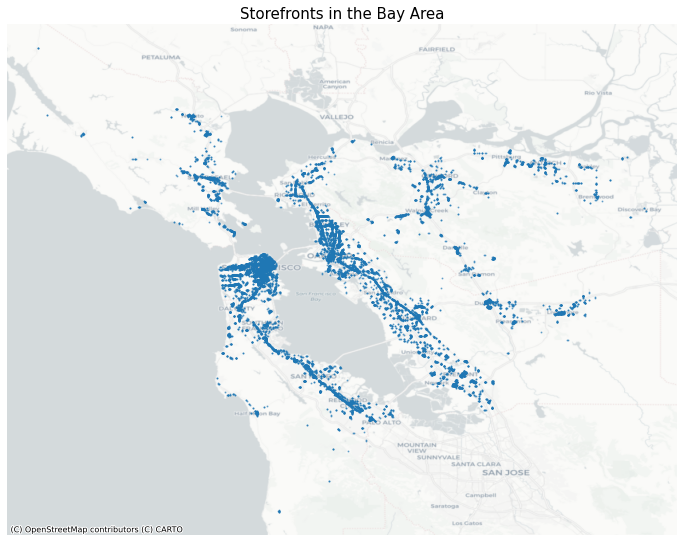

In [22]:
fig, ax = plt.subplots(figsize=(12,12))
storefronts.plot(markersize=1, ax=ax, alpha=0.5)
ax.axis('off')
ax.set_title("Storefronts in the Bay Area", fontsize=15)
cx.add_basemap(
    ax,
    crs=storefronts.crs.to_string(),
    source=cx.providers.CartoDB.Positron)
plt.show()

In the code above, the `source=` argument of `cx.add_basemap()` let's you choose from a number of different map tile providers. Check out the documentation [here](https://contextily.readthedocs.io/en/latest/intro_guide.html#Providers) to see all of the available options.

### Exercise:

Play around with different combinations of matplotlib marker styles (color, shape, opacity) and basemap styles until you find the one you think is best. Does the basemap provide useful context than the coast line shapefile we used before? Or does it add visual noise?

## 2.3. Custom choropleth geometries

In Section 2 above, we used a density metric to avoid the effect of the modifiable areal unit problem in our Census Tract map of storefront counts. As we've seen before, an alternative approach is to define your own equal-area geometries. For simple count data, this is usually the preferred method, since administrative boundaries don't really provide useful context anyways.

### 2.3.1 GeoPandas + Matplotlib Hexbins

This code illustrates how you can mix-and-match map shapes with other kinds of data visualizations and annotations in Matplotlib. It can take a while to work out all the syntax to accomplish things like this, but it's quite powerful.

First we'll need to pull latitude and longitude out into normal DataFrame columns

In [13]:
storefronts['lon'] = storefronts.geometry.x
storefronts['lat'] = storefronts.geometry.y

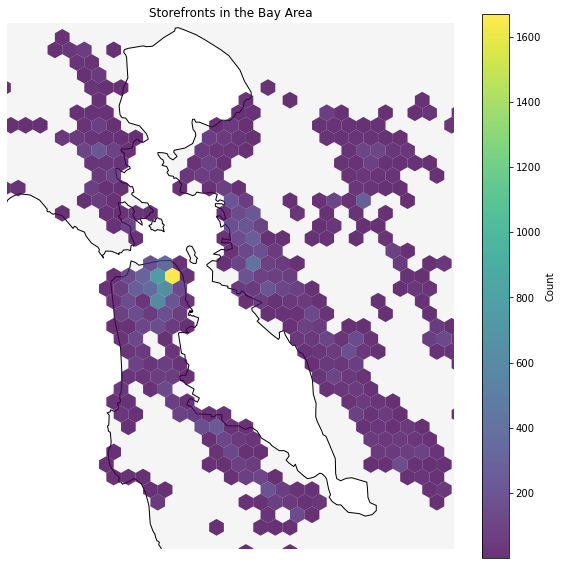

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

# Plot coastline using GeoPandas
outlines.plot(ax=ax, color='whitesmoke', edgecolor='black')

# Plot hexbins of storefronts using Matplotlib
hb = plt.hexbin(storefronts.lon, storefronts.lat, mincnt=1, gridsize=50, alpha=.8, lw=0)

# Add a key
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Count')


# Title and bounds
ax.set_title('Storefronts in the Bay Area')
ax.set_xlim((-122.7, -121.9))
ax.set_ylim((37.4, 38.15))

ax.axis('off')
plt.show()

### 2.3.2. Custom hexbins with `h3` and `tobler`

`h3` is an open-source hexagonal geospatial index developed by a ridehailing company. Together, the hexagons define hierarchical **discrete global grid**, meaning it covers the surface of the earth, with no gaps, at multiple levels of resolution.
<center><img src="https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/06/Twitter-H3-768x384.png"></center>

`h3py` is the official Python binding for using `h3` in Python, which you can find here: https://github.com/uber/h3-py. For this exercise, we're going to use a library called `tobler` instead, but you'll still need to install the underling `h3py` package (`pip install h3`).

`tobler` is another great library from the `PySAL` folks which let's us easily extract h3 geometries using a GeoPandas `GeoDataFrame` object. Tbler allows us to pass in a gdf and it'll return the requesed geometry

In [30]:
import tobler
from tobler.util import h3fy
from tobler.area_weighted import area_interpolate
import h3

In [31]:
tracts_proj = tracts.to_crs('epsg:26910')

In [32]:
hexes = h3fy(tracts_proj, resolution=7, clip=True)
print(type(hexes))

/Users/bukolaanifowoshe/opt/anaconda3/envs/cleanenv/lib/python3.10/site-packages/tobler/util/util.py:141: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  hexids = pandas.Series(


<class 'geopandas.geodataframe.GeoDataFrame'>


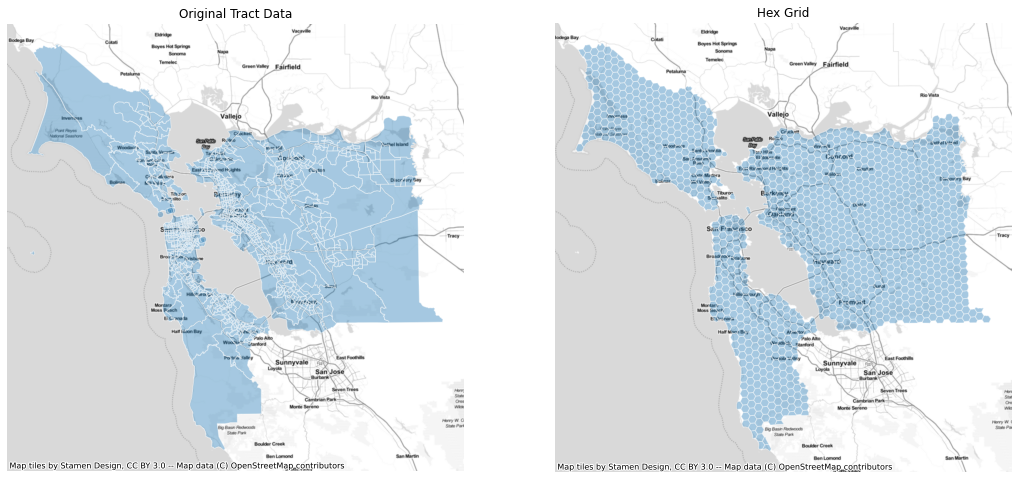

In [33]:
fig, axs = plt.subplots(1,2, figsize=(18,10))
axs=axs.flatten()

tracts_proj.plot(ax=axs[0], alpha=0.4, linewidth=1, edgecolor='white')
hexes.plot(ax=axs[1], alpha=0.4, linewidth=1, edgecolor='white')

axs[0].set_title('Original Tract Data')
axs[1].set_title('Hex Grid')

for i,_ in enumerate(axs):
    cx.add_basemap(
        axs[i],
        crs=hexes.crs.to_string(),
        source=cx.providers.Stamen.TonerLite)
    axs[i].axis('off')

Now we can use the same code we used to the tract count map, but with the hexes as our aggregation geometries

In [34]:
hexes = hexes.reset_index()
hexes_w_stores = gpd.sjoin(storefronts, hexes.to_crs(storefronts.crs), how='inner', predicate='within')
hexes_counts = hexes_w_stores.groupby('hex_id')['storefront_id'].count().reset_index()
hexes = pd.merge(hexes, hexes_counts, on='hex_id', how='left')
hexes['store_count'] = hexes['storefront_id'].fillna(0)
hexes = hexes.clip(outlines.to_crs(hexes.crs))  # clip tract geoms to coastline

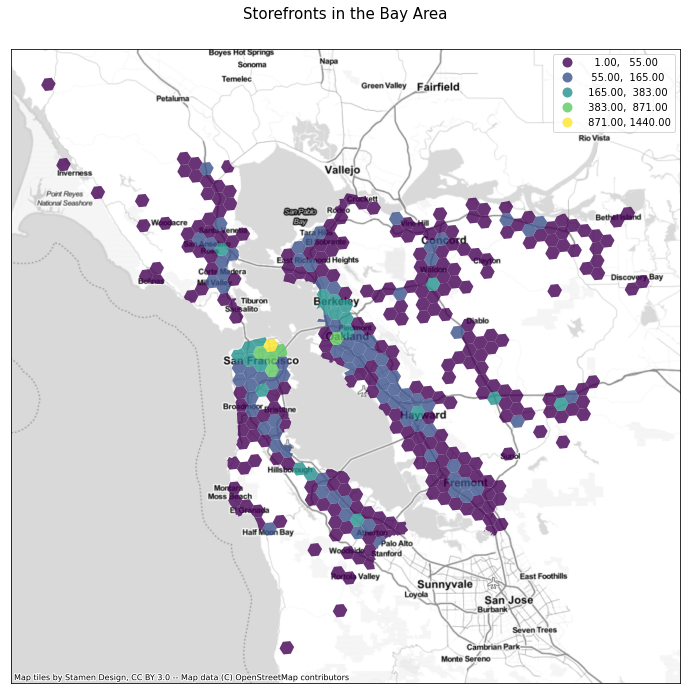

In [35]:
fig, ax = plt.subplots(figsize=(12, 12))

hexes[hexes['store_count'] > 0].plot(
    column='store_count',
    ax=ax,
    legend=True,
    scheme='naturalbreaks',
    alpha=0.8    
)

cx.add_basemap(
    ax,
    crs=hexes.crs.to_string(),
    source=cx.providers.Stamen.TonerLite)
ax.set_title("Storefronts in the Bay Area", fontsize=15, pad=30)

ax.set_xticks([])
ax.set_yticks([])
plt.show()

### Exercise

Try experimenting with different `h3` resolutions and classification schemes!

### 2.3.3. Areal Interpolation

As we've seen, there are many advantages to using exogenously defined, arbitrary geometries to display geospatial data. By aggregating point data to equal-area bins, we can avoid the visual biases imposed by both the plotting of raw points (overlapping, crowded geometries) and administrative boundaries (e.g. MAUP). It is also super straightforward to assign points to polygons, as it will almost always be a one-to-one relationship.

But what about non-point-based data? What if you are using Census data, which is only reported for administrative geometries like Census Tracts and Blocks? 

This would require some kind of mapping of hexbins to administrative boundaries, or vice versa. This can be tricky to do, as it is highly unlikely that the mappings will be one-to-one. More likely, the administrative boundaries will be split across reference geometries, or contain multiple reference geometries, depending on their relative sizes. Additionally, the result might change depending on the kind of spatial join you use to perform the operation (e.g. `contains`, `within`, `touches`, `overlaps`, etc.). The use case for hexbins here is less obvious, but let's go with it for now.

The simplest approach would probably to do an `intersects` operation, but this might return multiple hexbins for each administrative boundary. In this case, you might consider simpling mapping each administrative boundary to the hexbin with which it has the highest degree of overlap.The result might look something like this:

<center><img src="images/hex1.png"></center>

<center><img src="images/hex2.png"></center>

<center><img src="images/hex3.png"></center>

<center><img src="images/hex4.png"></center>

These images might be nice to look at, but they also highlight how messy it can be to map polygons to one another. You'll also still need to aggregate the data from the administrative zones to the hexbins, and clearly some of these aggregations will contain more error than others.

A more rigorous approach would also involve computing the degree of overlap between polygons, but then using that overlap to allocate the data proportionally from the administrative boundaries to the hexbins. Essentially slicing your data up. You can imagine how you might due this using a `union` overlay operation, and then performing an aggregation by hexbin using a weighted mean with weights defined by the area of smaller geometries. Sounds like a lot of work.

Fortunately, `tobler` has you covered. For this example we're going to pretend that we didn't have the original point data, but only the storefront density metric for each Census Tract:

In [36]:
hex_interpolated = area_interpolate(
    source_df=tracts_proj, target_df=hexes, intensive_variables=['store_density'])

/Users/bukolaanifowoshe/opt/anaconda3/envs/cleanenv/lib/python3.10/site-packages/tobler/util/util.py:32: UserWarning: nan values in variable: store_density, replacing with 0
  warn(f"nan values in variable: {column}, replacing with 0")


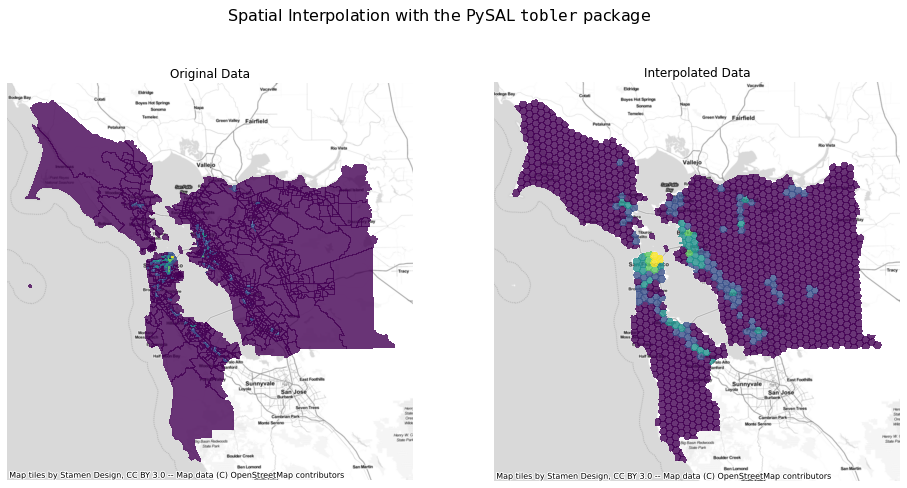

In [37]:
fig, axs = plt.subplots(1,2, figsize=(16, 8))

tracts_proj.plot(
    'store_density', scheme='fisherjenks', alpha=0.8, ax=axs[0], edgecolor='none', antialiased=False)
hex_interpolated.plot(
    'store_density', scheme='fisherjenks', alpha=0.8, ax=axs[1], edgecolor='none', antialiased=False)

axs[0].set_title('Original Data')
axs[1].set_title('Interpolated Data')
           
for ax in axs:
    cx.add_basemap(
        ax=ax,
        source=cx.providers.Stamen.TonerLite,
        crs=hexes.crs.to_string())
    ax.axis('off')

fig.suptitle('Spatial Interpolation with the PySAL $\mathtt{tobler}$ package', fontsize=16)

plt.show()

Here we're interpolating the value of the density metric rather than the point counts. Why might it be a bad idea to interpolate the point counts?

For more examples of interpolation, and different interpolation methods, check out the `tobler` documentation [here](https://pysal.org/tobler/notebooks/01_interpolation_methods_overview.html) 

## 2.4. Dot-density maps -- alternative to choropleth

A useful alternative to the choropleth map which avoids both MAUP and aggregation bias is the dot-density map. These became very popular around the time of the 2010 Decennial Census due to a racial dot density map of Chicago made by Professor Bill Rankin (a.k.a. [Radical Cartography](http://www.radicalcartography.net/index.html?chicagodots))

<center><img src="http://www.radicalcartography.net/chicagodots_race_lines.jpg" width=500></center>

Some other really fascinating examples followed from the [Cooper Center](https://demographics.coopercenter.org/racial-dot-map) at the University of Virginia, and Bay Area cartographer [Erica Fischer](https://commons.wikimedia.org/wiki/Category:Race_and_Ethnicity_by_Eric_Fischer_(2010_Census_data))

Detroit


<center><img src="https://www.gannett-cdn.com/-mm-/c1fd377bdd190832b44b31a5c9345a838610929b/c=0-2-1489-843/local/-/media/2015/09/01/DetroitFreePress/DetroitFreePress/635767091539964541-race.JPG"></center>

To find out more about dot-density maps, what they do well and what they do not-so-well, check out the ever-useful Axis Maps cartography guide [here](https://www.axismaps.com/guide/dot-density)

### Exercise:

Rather than re-create the wheel, check out [this](http://andrewgaidus.com/Dot_Density_County_Maps/) step-by-step guide for creating dot density maps in Python. Copy-paste that code into this notebook and try to create your own!

# 3. Final project breakout groups

# 4. For next time

# 5. Questions?